In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

#station list for BK is here: https://www.ncedc.org/pub/doc/BK.info/BK.channel.summary.day
#station map for BK is here: https://seismo.berkeley.edu/networks/index.html

# Initialize client for the data center
client = Client("NCEDC")  # replace "IRIS" with the appropriate data center if different

# Define the parameters for data retrieval
network = "BK"  # replace with the appropriate network code
station = "JRSC"  # replace with the appropriate station code

#ADAM is Farallon, due north
#LLNL is Farallon, due east
#JRSC is Farallon, due south
#FARB is Farallon, due west

location = "00"  # replace with the location code
channel = "BHE"  # replace with the channel code
start_time = UTCDateTime("2023-06-20T15:00:00")  # specify your start time
end_time = UTCDateTime("2024-06-20T22:00:00")    # specify your end time

# Download the data
st = client.get_waveforms(network, station, location, channel, start_time, end_time)

# Downsample the data in-place to a desired rate (e.g., 10 Hz)
st.resample(0.05)  # replace 10.0 with your desired sampling rate in Hz

# Save the downsampled data to a file if needed
st.write("downsampled_data.mseed", format="MSEED")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [2]:
import pandas as pd
# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over each Trace in the Stream
for trace in st:
    # Get the start time of the trace
    start_time = trace.stats.starttime

    # Create a time index for the trace
    time_index = pd.date_range(start=start_time.datetime, periods=trace.stats.npts, freq=f"{trace.stats.delta}s")

    # Create a DataFrame for the trace
    trace_df = pd.DataFrame(data=trace.data, index=time_index, columns=["amplitude"])

    # Add metadata columns
    trace_df["network"] = trace.stats.network
    trace_df["station"] = trace.stats.station
    trace_df["location"] = trace.stats.location
    trace_df["channel"] = trace.stats.channel

    # Append the trace DataFrame to the main DataFrame
    df = pd.concat([df, trace_df])

# Reset the index to have 'timestamp' as a column
df.reset_index(inplace=True)
df.rename(columns={"index": "timestamp"}, inplace=True)
# Set the timestamp column as the index
df.drop(columns=["network", "station", "location", "channel"], inplace=True)

# Display the first few rows of the DataFrame
print(df.head())

                   timestamp    amplitude
0 2023-06-20 15:00:00.019538   468.765830
1 2023-06-20 15:00:20.019538  1927.948158
2 2023-06-20 15:00:40.019538  1866.877818
3 2023-06-20 15:01:00.019538   921.251536
4 2023-06-20 15:01:20.019538   505.886654


In [3]:
# Convert the 'timestamp' column to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set 'timestamp' as the index
df = df.set_index('timestamp')

In [4]:
df.shape

(1578059, 1)

In [5]:
#resample
resampled_df = df.resample('30T').mean().dropna()
print(resampled_df.head())
print(resampled_df.tail())

                      amplitude
timestamp                      
2023-06-20 15:00:00  395.233483
2023-06-20 15:30:00  -84.099413
2023-06-20 16:00:00    9.917063
2023-06-20 16:30:00  194.174527
2023-06-20 17:00:00  171.021456
                      amplitude
timestamp                      
2024-06-20 19:30:00  -95.876303
2024-06-20 20:00:00  -99.348776
2024-06-20 20:30:00 -116.159502
2024-06-20 21:00:00  -88.187810
2024-06-20 21:30:00 -114.994879


/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_25997/2802925619.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = df.resample('30T').mean().dropna()


In [6]:
print(resampled_df.shape)

(17534, 1)


In [7]:
#now fill in blank dates: 

# Create a complete range of 30-minute intervals based on the min and max timestamps
all_times = pd.date_range(start=resampled_df.index.min(), end=resampled_df.index.max(), freq='30min')

# Reindex the DataFrame to include all 30-minute intervals, filling missing values with NaN
complete_df = resampled_df.reindex(all_times)

# Use forward-fill to fill missing values
complete_df.ffill(inplace=True)


In [8]:
complete_df.shape

(17582, 1)

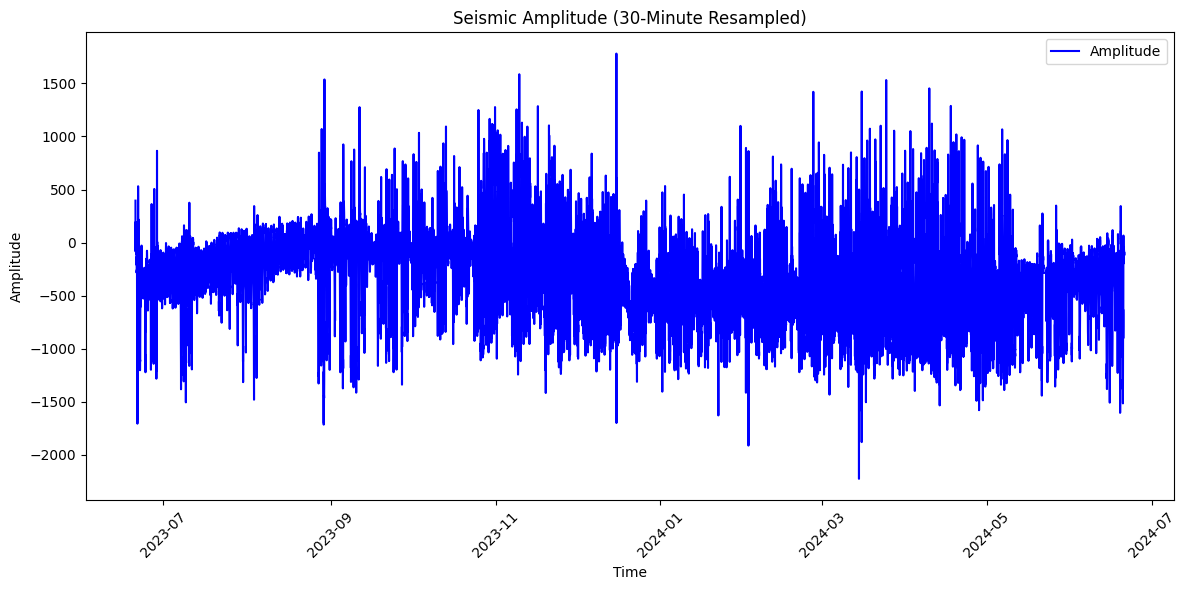

In [9]:
import matplotlib.pyplot as plt

# Plot the resampled amplitude over time
plt.figure(figsize=(12, 6))
plt.plot(complete_df.index, complete_df['amplitude'], label='Amplitude', color='blue')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismic Amplitude (30-Minute Resampled)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Trim the data to the specified date range
trimmed_data = resampled_df.loc[start_date:end_date]

trimmed_data.tail()

,amplitude
timestamp,
2024-06-20 18:30:00,-99.599502
2024-06-20 19:00:00,-68.308071
2024-06-20 19:30:00,-95.876303
2024-06-20 20:00:00,-99.348776
2024-06-20 20:30:00,-116.159502


In [11]:
trimmed_data.head()

,amplitude
timestamp,
2023-06-21 15:00:00,388.417131
2023-06-21 15:30:00,-70.584967
2023-06-21 16:00:00,71.601174
2023-06-21 16:30:00,219.489946
2023-06-21 17:00:00,196.549379


In [12]:
# Create a complete range of 30-minute intervals based on the min and max timestamps
all_times = pd.date_range(start=trimmed_data.index.min(), end=trimmed_data.index.max(), freq='30min')

# Reindex the DataFrame to include all 30-minute intervals, filling missing values with NaN
complete_df = trimmed_data.reindex(all_times)

# Use forward-fill to fill missing values
complete_df.ffill(inplace=True)

In [13]:
complete_df.shape

(17532, 1)

In [14]:
complete_df['smoothed_amplitude'] = complete_df['amplitude'].rolling(window=4).mean()

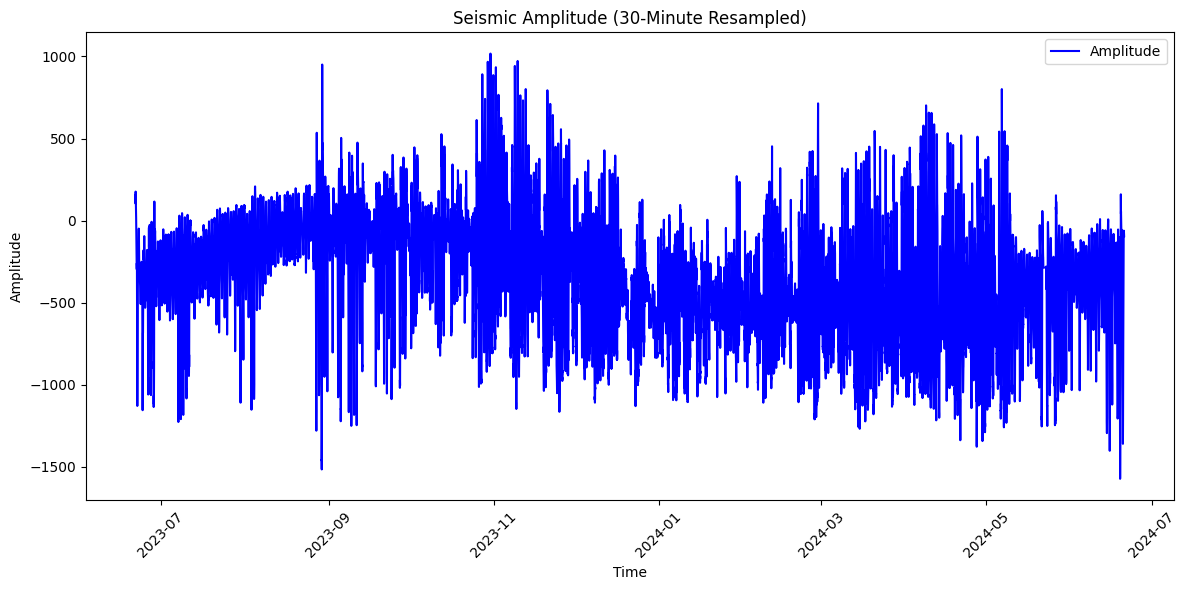

In [15]:
# Plot the resampled amplitude over time
plt.figure(figsize=(12, 6))
plt.plot(complete_df.index, complete_df['smoothed_amplitude'], label='Amplitude', color='blue')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismic Amplitude (30-Minute Resampled)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



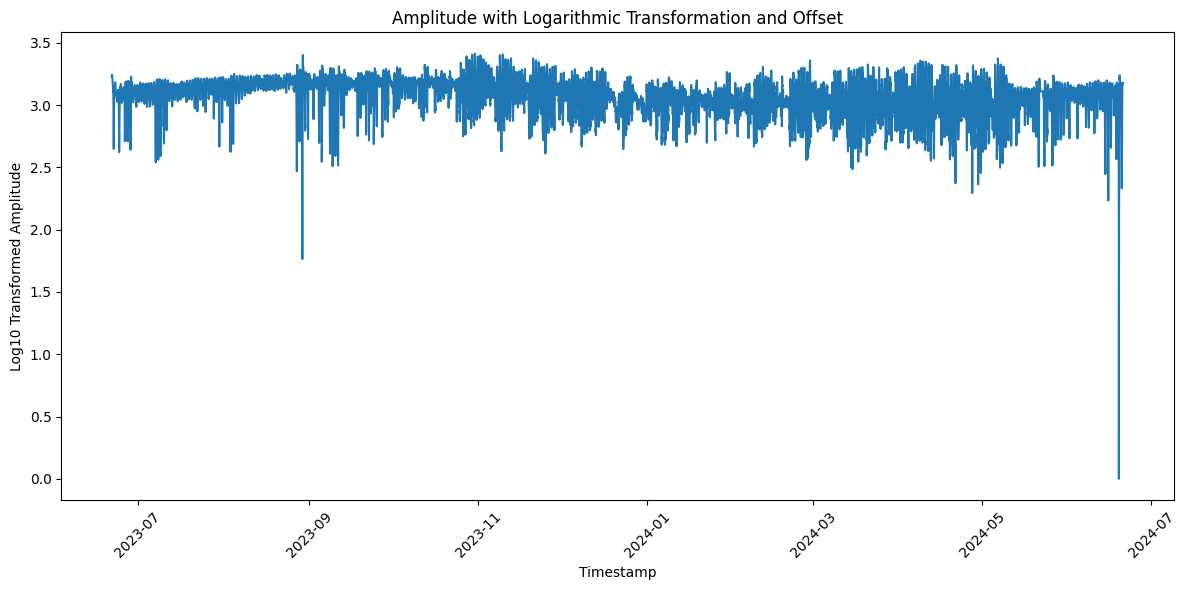

In [16]:
import numpy as np

# Determine an offset to make all values positive (e.g., based on the min value)
offset = abs(complete_df['smoothed_amplitude'].min()) + 1  # Add 1 to ensure all values are positive

# Apply the log transformation with the offset
complete_df['amplitude_log'] = np.log10(complete_df['smoothed_amplitude'] + offset)

# Plot the transformed data
plt.figure(figsize=(12, 6))
plt.plot(complete_df.index, complete_df['amplitude_log'], linestyle='-')
plt.title("Amplitude with Logarithmic Transformation and Offset")
plt.xlabel("Timestamp")
plt.ylabel("Log10 Transformed Amplitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
normalized_df = complete_df.copy()
normalized_df['amplitude_log'] = (complete_df['amplitude_log'] - complete_df['amplitude_log'].min()) / (complete_df['amplitude_log'].max() - complete_df['amplitude_log'].min())

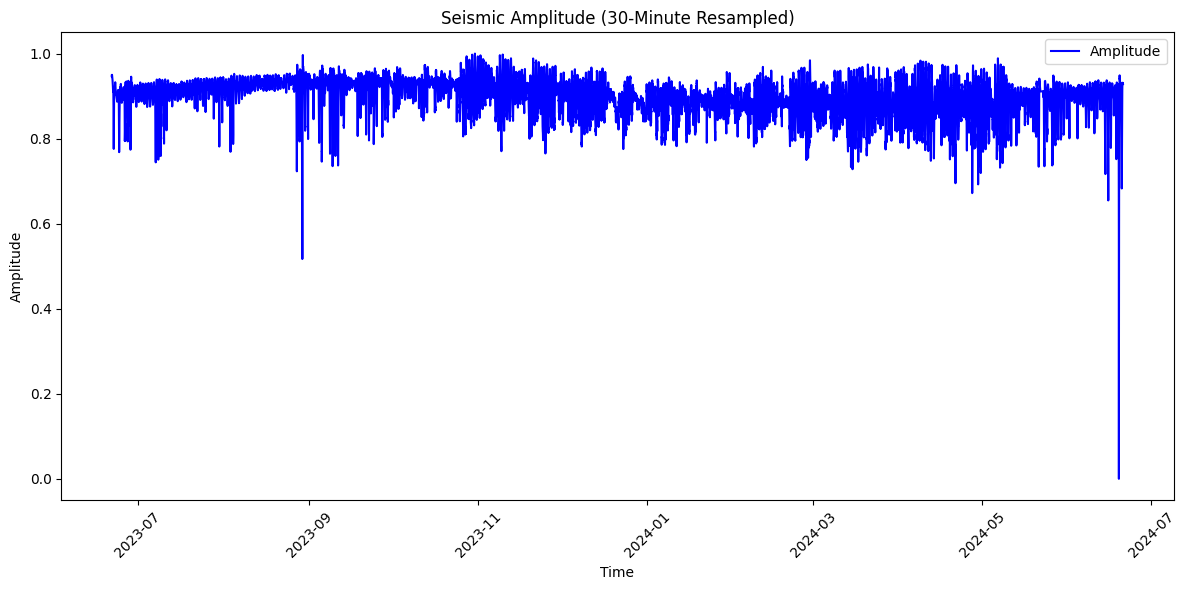

In [18]:
# Plot the resampled amplitude over time
plt.figure(figsize=(12, 6))
plt.plot(normalized_df.index, normalized_df['amplitude_log'], label='Amplitude', color='blue')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Seismic Amplitude (30-Minute Resampled)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
print(normalized_df['amplitude_log'].mean())

0.8969503875951439


In [20]:
normalized_df.shape

(17532, 3)

In [21]:
normalized_df.to_csv("../data/"+station+"_seismic_2023_2024.csv", index = True)